In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from scipy.special import softmax
from time import perf_counter

In [2]:
from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import encode_categorical
from sksurv.metrics import integrated_brier_score, concordance_index_censored
from sksurv.tree import SurvivalTree

In [3]:
from gradient_growing_trees.tree import GradientGrowingTreeRegressor

Here we implement simple conversion from survival targets to Generalized Log Loss targets:

In [4]:
def survival_to_logloss_targets(cens: np.ndarray, time: np.ndarray, time_grid: np.ndarray):
    targets = np.zeros((time.shape[0], time_grid.shape[0]), dtype=np.uint8)
    time = np.maximum(time, np.min(time_grid))
    grid_ids_at_time = np.searchsorted(time_grid[1:], time, side='right')
    mask = (cens == 1)
    targets[np.argwhere(mask).ravel(), grid_ids_at_time[mask]] = 1
    inv_mask = ~mask
    ones_triu = np.triu(np.ones(targets.shape, dtype=np.uint8))  # , 1)
    targets[inv_mask] = ones_triu[grid_ids_at_time[inv_mask]]
    return targets


In [5]:
def make_comparison(X, y, models, depth_range=(1, 9), n_repeats=20, n_splits=5):
    all_results = dict()

    for depth in range(*depth_range):
        rand_results = defaultdict(dict)
        for name, model_factory in models.items():
            cur_res = []
            cur_brier = []
            cur_times = []
            for s in range(n_repeats):
                kfold = KFold(n_splits=n_splits, shuffle=True, random_state=s)
                for i, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
                    m = model_factory(depth)

                    cur_y = y[train_idx]
                    unique_times = np.unique(cur_y['time'])
                    if isinstance(m, GradientGrowingTreeRegressor):
                        cur_y = survival_to_logloss_targets(cur_y['cens'], cur_y['time'], unique_times).astype(np.float64)

                    before_time = perf_counter()
                    m.fit(X[train_idx], cur_y)
                    after_time = perf_counter()

                    if not isinstance(m, GradientGrowingTreeRegressor):
                        preds = m.predict_survival_function(X[test_idx], return_array=True)
                    else:
                        pred_probas = softmax(m.predict(X[test_idx]).squeeze(2), axis=1)
                        preds = 1. - np.insert(np.cumsum(pred_probas, axis=1), 0, 0, axis=1)[:, :-1]

                    c_index, *_ = concordance_index_censored(
                        y[test_idx]['cens'],
                        y[test_idx]['time'],
                        -np.trapezoid(preds, unique_times, axis=-1)
                    )
                    cur_res.append(c_index)
                    n_left = np.searchsorted(unique_times, np.min(y[test_idx]['time']))
                    n_right = np.searchsorted(unique_times, np.max(y[test_idx]['time']))
                    cur_brier.append(integrated_brier_score(
                        y[train_idx],
                        y[test_idx],
                        preds[:, n_left:n_right],
                        unique_times[n_left:n_right]
                    ))
                    cur_times.append(after_time - before_time)
            rand_results[name]['C-index'] = np.array(cur_res)
            rand_results[name]['Brier'] = np.array(cur_brier)
            rand_results[name]['time'] = np.array(cur_times)
        all_results[depth] = rand_results

    df_data = defaultdict(list)

    for d, res in all_results.items():
        for name, metric_values in res.items():
            for metric, values in metric_values.items():
                for v in values:
                    df_data['name'].append(name)
                    df_data['depth'].append(d)
                    df_data['metric'].append(metric)
                    df_data['value'].append(v)

    df = pd.DataFrame(df_data)
    return df


In [6]:
gbsg2_X, gbsg2_y = load_gbsg2()
gbsg2_X = encode_categorical(gbsg2_X, columns=['horTh', 'menostat', 'tgrade']).values

In [7]:
models = {
    'SurvTree': lambda d: SurvivalTree(max_depth=d),
    'l2=0.05': lambda d: GradientGrowingTreeRegressor(lam_2=0.05, lr=1.0, criterion='batch_gce', splitter='best', max_depth=d, random_state=1),
    'l2=0.1': lambda d: GradientGrowingTreeRegressor(lam_2=0.1, lr=1.0, criterion='batch_gce', splitter='best', max_depth=d, random_state=1),
    'l2=0.2': lambda d: GradientGrowingTreeRegressor(lam_2=0.2, lr=1.0, criterion='batch_gce', splitter='best', max_depth=d, random_state=1),
    'l2=0.5': lambda d: GradientGrowingTreeRegressor(lam_2=0.5, lr=1.0, criterion='batch_gce', splitter='best', max_depth=d, random_state=1),
}

In [8]:
df = make_comparison(gbsg2_X, gbsg2_y, models, depth_range=(1, 31), n_repeats=4)

In [9]:
t = pd.pivot_table(df.query('metric == "C-index"'), values='value', index='depth', columns='name').style.highlight_max(
    axis=1,
    props="font-weight: bold",
).format("{:0.3f}")
t

name,SurvTree,l2=0.05,l2=0.1,l2=0.2,l2=0.5
depth,,,,,
1,0.564,0.571,0.572,0.572,0.572
2,0.606,0.585,0.587,0.585,0.585
3,0.638,0.594,0.594,0.593,0.591
4,0.648,0.604,0.600,0.597,0.597
5,0.642,0.600,0.602,0.604,0.597
6,0.638,0.589,0.607,0.604,0.597
7,0.630,0.612,0.605,0.605,0.596
8,0.622,0.631,0.605,0.607,0.600
9,0.617,0.643,0.606,0.608,0.601


<Axes: xlabel='depth', ylabel='C-index'>

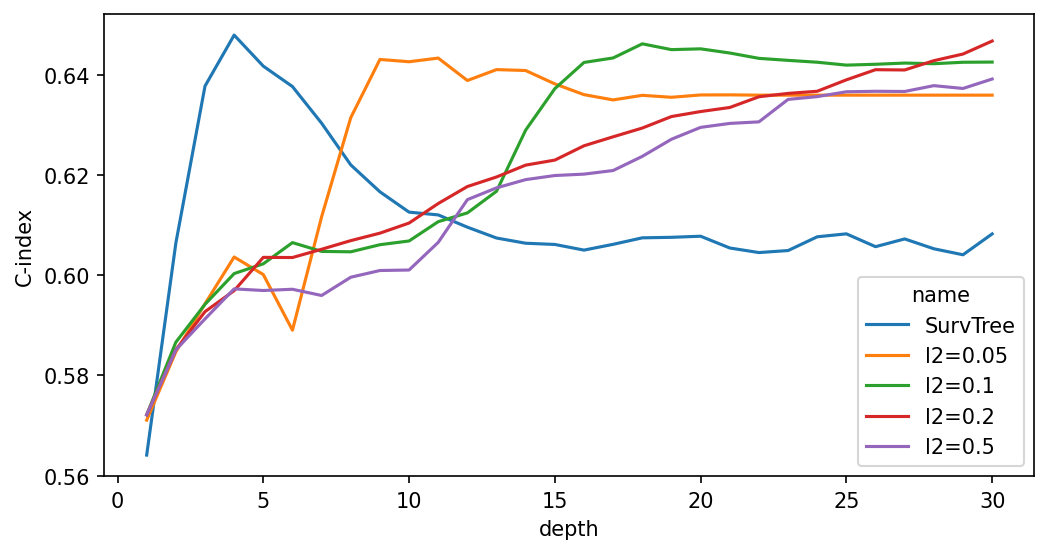

In [10]:
plt.figure(figsize=(8, 4), dpi=150)
sns.lineplot(
    df.query('metric == "C-index"').rename({'value': 'C-index'}, axis=1),
    x='depth', y='C-index', hue='name', errorbar=None
)

**The same experiment with `n_update_iterations=5`**:

In [11]:
common_params = dict(
    lr=1.0,
    criterion='batch_gce',
    splitter='best',
    random_state=1,
    n_update_iterations=5
)

models_5 = {
    'SurvTree': lambda d: SurvivalTree(max_depth=d),
    'l2=0.05': lambda d: GradientGrowingTreeRegressor(lam_2=0.05, max_depth=d, **common_params),
    'l2=0.1': lambda d: GradientGrowingTreeRegressor(lam_2=0.1, max_depth=d, **common_params),
    'l2=0.2': lambda d: GradientGrowingTreeRegressor(lam_2=0.2, max_depth=d, **common_params),
    'l2=0.5': lambda d: GradientGrowingTreeRegressor(lam_2=0.5, max_depth=d, **common_params),
    'l2=1.0': lambda d: GradientGrowingTreeRegressor(lam_2=1.0, max_depth=d, **common_params),
    'l2=5.0': lambda d: GradientGrowingTreeRegressor(lam_2=5.0, max_depth=d, **common_params),
}

In [12]:
df_5 = make_comparison(gbsg2_X, gbsg2_y, models_5, depth_range=(1, 21), n_repeats=4)

In [13]:
t = pd.pivot_table(df_5.query('metric == "C-index"'), values='value', index='depth', columns='name').style.highlight_max(
    axis=1,
    props="font-weight: bold",
).format("{:0.3f}")
t

name,SurvTree,l2=0.05,l2=0.1,l2=0.2,l2=0.5,l2=1.0,l2=5.0
depth,,,,,,,
1,0.564,0.562,0.584,0.576,0.573,0.573,0.572
2,0.606,0.621,0.620,0.594,0.593,0.589,0.587
3,0.638,0.631,0.640,0.634,0.603,0.595,0.591
4,0.648,0.638,0.638,0.644,0.609,0.602,0.597
5,0.642,0.625,0.629,0.641,0.606,0.609,0.597
6,0.638,0.628,0.612,0.640,0.613,0.604,0.596
7,0.631,0.609,0.615,0.638,0.636,0.608,0.597
8,0.624,0.611,0.608,0.639,0.642,0.606,0.602
9,0.617,0.602,0.610,0.631,0.641,0.610,0.604


<Axes: xlabel='depth', ylabel='C-index'>

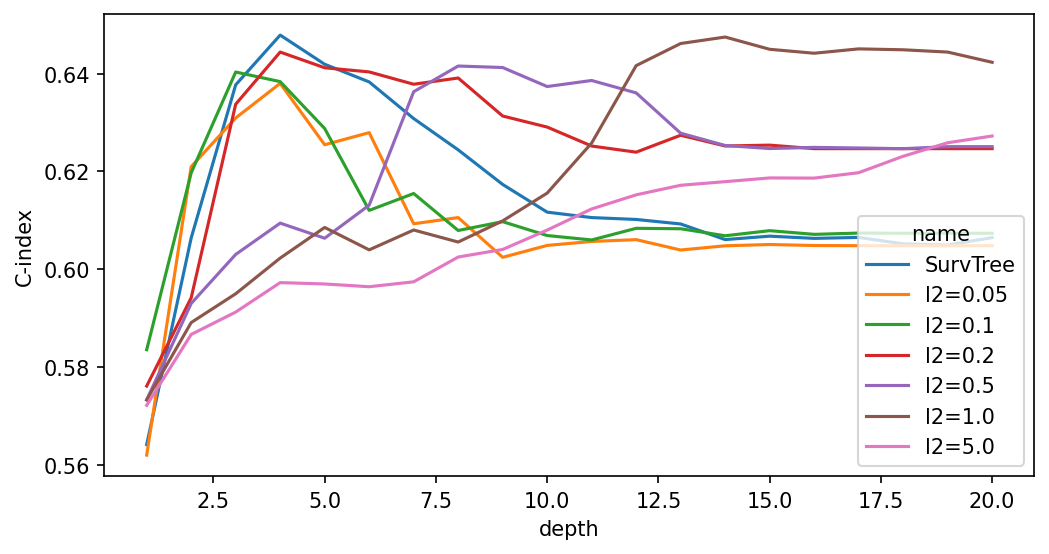

In [14]:
plt.figure(figsize=(8, 4), dpi=150)
sns.lineplot(
    df_5.query('metric == "C-index"').rename({'value': 'C-index'}, axis=1),
    x='depth', y='C-index', hue='name', errorbar=None
)